# BM3 GNN Pred

In [1]:
from typing import *
import numpy as np
from functools import partial

import torch
from torch import Tensor, nn
import torch.nn.functional as F

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

In [2]:
DEVICE = torch.device("cpu")

In [3]:
from tomopt.volume.layer import Layer

def get_volume(size: float = 0.2, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(0.5, 0.5, 1 - (i * (size) / n_panels)), init_xy_span=(1.0, 1.0), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - size, size, -size), decimals=1):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(0.5, 0.5, 0.2 - (i * (size) / n_panels)), init_xy_span=(1.0, 1.0), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [4]:
volume = get_volume(device=DEVICE)

In [5]:
muons = MuonBatch(generate_batch(250), init_z=volume.h, device=DEVICE)

In [6]:
gen = RandomBlockPassiveGenerator(
        block_size=None, volume=volume, sort_x0=False, enforce_diff_mat=True, materials=["beryllium", "carbon", "silicon", "iron", "lead"], block_size_max_half=False
    )

In [7]:
volume.load_rad_length(*gen.get_data())

In [8]:
volume(muons)

In [9]:
volume.target

tensor([0.0176])

In [10]:
sb = PanelScatterBatch(muons, volume)

## GNN inferer

In [11]:
model = torch.jit.load('../../mode_muon_tomo_inference/dev/exported_models/bm3_traced.pt')

In [12]:
type(model)

torch.jit._script.RecursiveScriptModule

In [13]:
dvi = DeepVolumeInferer(model=model, base_inferer=PanelX0Inferer(volume), volume=volume)

In [14]:
dvi.in_vars, dvi.in_var_uncs

([], [])

In [15]:
dvi.add_scatters(sb)

/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/scattering.py:246: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


In [16]:
dvi.in_vars[0].shape, dvi.in_var_uncs[0].shape

(torch.Size([250, 8]), torch.Size([250, 8]))

In [17]:
%%time
p,w = dvi.get_prediction()

CPU times: user 3.65 s, sys: 323 ms, total: 3.98 s
Wall time: 1.51 s


In [18]:
torch.exp(p).shape

torch.Size([1, 5, 125])

In [19]:
p

tensor([[[-4.9859, -4.3441, -4.0862, -4.2465, -4.7861, -4.1996, -3.5097,
          -3.2379, -3.4431, -4.0853, -3.9152, -3.2508, -2.9698, -3.1729,
          -3.8160, -4.0961, -3.4829, -3.2172, -3.3851, -3.9628, -4.6255,
          -4.1078, -3.8594, -4.0149, -4.5302, -3.7786, -3.1006, -2.8829,
          -3.1722, -3.9106, -2.8925, -2.3366, -2.1920, -2.3999, -3.0878,
          -2.6015, -2.1567, -2.0664, -2.1992, -2.8020, -2.7500, -2.3429,
          -2.2264, -2.3728, -2.9221, -3.3157, -2.8449, -2.7301, -2.8902,
          -3.5387, -2.9541, -2.2819, -2.1912, -2.4708, -3.2885, -2.0381,
          -1.7776, -1.7784, -1.8867, -2.4262, -1.7876, -1.6746, -1.6957,
          -1.7920, -2.1780, -1.8848, -1.6763, -1.7207, -1.8170, -2.2532,
          -2.3971, -1.9619, -1.9132, -2.1159, -2.7685, -2.8121, -2.0475,
          -1.9053, -2.2176, -3.0846, -1.8333, -1.3955, -1.4380, -1.6157,
          -2.1992, -1.5263, -1.2724, -1.3327, -1.4810, -1.9045, -1.6448,
          -1.2884, -1.3242, -1.4738, -1.9883, -2.24

In [20]:
%%time
# jacobian(p, dvi.in_var)  # crashes

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs


## Loss

In [21]:
x02id = {X0[m]: i for i, m in enumerate(gen.materials)}; x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [22]:
loss = VoxelClassLoss(x02id=x02id, target_budget=None)

In [23]:
l = loss(p, 1, volume); l

Automatically setting cost coefficient to 2.2525079250335693


tensor([2.2525], grad_fn=<AddBackward0>)

In [24]:
jacobian(l, volume.get_detectors()[0].panels[0].xy)

tensor([[-0.1251,  0.5511]])

In [25]:
jacobian(l, volume.get_detectors()[0].panels[0].xy_span)

tensor([[-0.0106,  0.2029]])

In [26]:
jacobian(l, volume.get_detectors()[0].panels[0].z)

tensor([[61.0667]])

## Plotting

In [27]:
class_preds = p.argmax(1).detach().cpu().numpy()

In [28]:
true = volume.get_rad_cube().flatten().reshape((5,5,5))

In [29]:
class_preds = class_preds.reshape(true.shape)

In [30]:
id2x0 = {v:k for k,v in x02id.items()}; id2x0

{0: 0.3528, 1: 0.1932, 2: 0.0937, 3: 0.01757, 4: 0.005612}

In [31]:
def class_to_x0preds(array: np.ndarray, id2x0: Dict[int, float]) -> np.ndarray:
    x0array = np.zeros_like(array, dtype='float32')
    for i in np.unique(array):
        x0array[array == i] = id2x0[i]
    return x0array

In [32]:
x0_preds = class_to_x0preds(class_preds, id2x0)

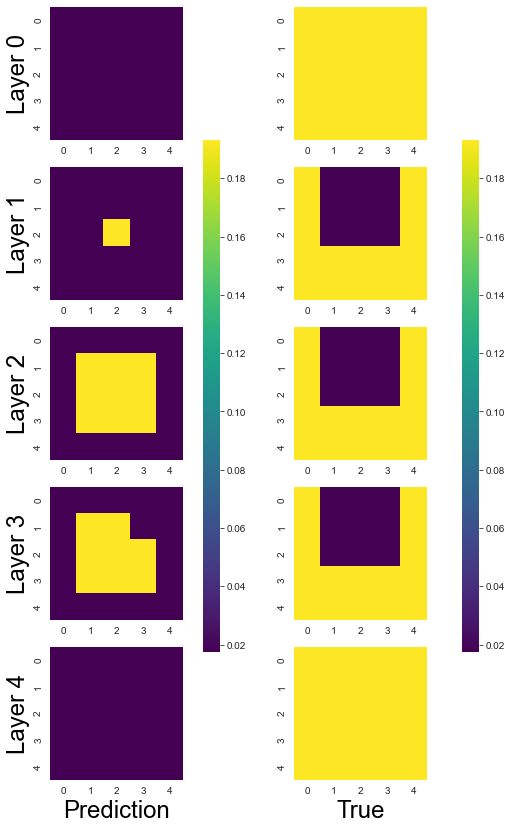

In [33]:
plot_pred_true_x0(x0_preds, true)

In [34]:
def x0targs_to_classtargs(array: np.ndarray, x02id: Dict[float, int]) -> np.ndarray:
    x0array = np.zeros_like(array)
    for i in np.unique(array):
        x0array[array == i] = x02id[min(x02id, key=lambda x:abs(x-i))]
    return x0array

In [35]:
x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [36]:
class_targs = x0targs_to_classtargs(true, x02id)

In [37]:
class_targs

array([[[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 3., 3., 3., 1.],
        [1., 3., 3., 3., 1.],
        [1., 3., 3., 3., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 3., 3., 3., 1.],
        [1., 3., 3., 3., 1.],
        [1., 3., 3., 3., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 3., 3., 3., 1.],
        [1., 3., 3., 3., 1.],
        [1., 3., 3., 3., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]], dtype=float32)

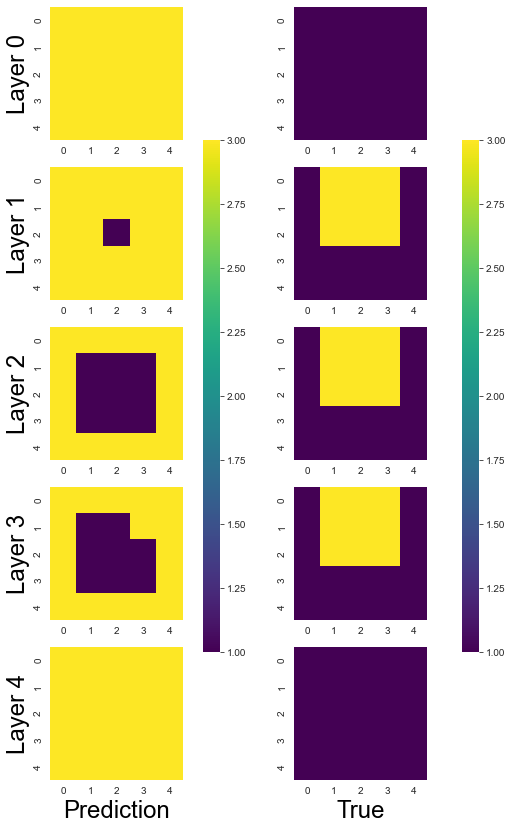

In [38]:
plot_pred_true_x0(class_preds, class_targs)